In [1]:
import numpy as np
from scipy.integrate import simps
import matplotlib.pyplot as plt
import pandas as pd
from math import sqrt,pow,log
import matplotlib.cm as cm
from scipy.integrate import quad
import h5py
from cobaya.run import run

In [2]:
!wget http://supernova.lbl.gov/Union/figures/SCPUnion2.1_mu_vs_z.txt
d = np.genfromtxt('SCPUnion2.1_mu_vs_z.txt')
z1 = d.T[1]
mu1 = d.T[2]
errmu= d.T[3]
dlabel = 'SCP_2.1'
label = {"Z_SN":z1,"DMdata_SN":mu1,"Error_DM_SN":errmu}
data_SN=pd.DataFrame(label)
#print(data_SN)
sort_data_SN=data_SN.sort_values(by=['Z_SN'],ignore_index=True)
!wget https://supernova.lbl.gov/Union/figures/SCPUnion2.1_covmat_sys.txt
cov_mat = np.genfromtxt('SCPUnion2.1_covmat_sys.txt')
z=sort_data_SN.Z_SN
mu=sort_data_SN.DMdata_SN

URL transformed to HTTPS due to an HSTS policy
--2022-02-18 17:21:44--  https://supernova.lbl.gov/Union/figures/SCPUnion2.1_mu_vs_z.txt
Resolving supernova.lbl.gov (supernova.lbl.gov)... 128.3.28.88
Connecting to supernova.lbl.gov (supernova.lbl.gov)|128.3.28.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33899 (33K) [text/plain]
Saving to: ‘SCPUnion2.1_mu_vs_z.txt.18’

SCPUnion2.1_mu_vs_z 100%[===================>]  33.10K  82.5KB/s    in 0.4s    

2022-02-18 17:21:46 (82.5 KB/s) - ‘SCPUnion2.1_mu_vs_z.txt.18’ saved [33899/33899]

--2022-02-18 17:21:46--  https://supernova.lbl.gov/Union/figures/SCPUnion2.1_covmat_sys.txt
Resolving supernova.lbl.gov (supernova.lbl.gov)... 128.3.28.88
Connecting to supernova.lbl.gov (supernova.lbl.gov)|128.3.28.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6037238 (5.8M) [text/plain]
Saving to: ‘SCPUnion2.1_covmat_sys.txt.13’

SCPUnion2.1_covmat_ 100%[===================>]   5.76M  1.03MB/s   

In [59]:
#omega_m, n , H0 SN
#number of samples 
sampl= 10000
#number of pars
par = 2


#assume the parameters have a gaussian distribution
sigma_omega= 0.01
sigma_n= 0.01
omega_b0 = 0.0000245
omega_r0=0.02

#Defining part which comes inside integeration of distance Luminosity

inv_cov_mat= np.linalg.inv(cov_mat)
dmthSN= np.zeros(len(z))
dlthSN = np.zeros(len(z))
dldataSN=np.zeros(len(z))
error= np.zeros(len(z))
dlerror= np.zeros(len(z))

a=b=c=d=e=0
# DL theoretical from VCG model
def D_l(z,omega_m,n,h0):
    def int_func(x):
        return 1/(pow((1+x),2)*(omega_r0+(omega_b0/(1+x))+((1-omega_b0-omega_r0)*((omega_m*(1+x)**6)+(1-omega_m)*(1+z)**n)**(0.5)/(1+x)**(4)))**(0.5))
    g = quad(int_func,0,z)
    return (1+z)*g[0]*(3000/(h0))
#Function to calculate the value of mu_theory
def mu_theory(z,omega_m,n,h0):
        m=5*log(D_l(z,omega_m,n,h0),10)+25
        return m


# We now defile a likelihood function as given in the notes
# If the value comes out to be less than zero, set it to a very very small likelyhood
#Temporary variable to store mu(observation)- mu(theory)
dmu= np.empty(len(z))
def lnl(omega_m, n,h0):
        if(omega_m<=0.0 or h0<0):
            loglikely=-1.e100
        else:
            for i in range(len(z)):
                dmu[i]= mu[i]- mu_theory(z[i],omega_m,n,h0)
            loglikely= -0.5*np.dot(dmu,np.dot(inv_cov_mat,dmu))
        return loglikely


In [64]:
info_SN = {
    "likelihood": {
        "external": lnl},
    "params": dict([
        ("omega_m", {
            "prior": {"min": 0, "max": 1.3},
            "latex": r"\Omega_m"}),
        ("n", {
            "prior": {"min": -3, "max": 2.2},
            "latex": r"n"}),
        ("h0", {
            "prior": {"min": 0, "max": 1},
            "latex": r"h0"}) ]),
    "sampler": {
        "mcmc": {"Rminus1_stop": 0.05, 'max_tries':500}}}

In [65]:
from cobaya.run import run

updated_info_SN, sampler_SN = run(info_SN)

[external] Initialized external likelihood.
[mcmc] Getting initial point... (this may take a few seconds)
[prior] Reference values or pdfs for some parameters were not provided. Sampling from the prior instead for those parameters.
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {external: 9.99}
[prior] *WARNING* Reference pdf not defined or improper for some parameters. Using prior's sigma instead for them.
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Initial point: omega_m:0.4518069, n:1.74562, h0:0.7866413
[mcmc] Sampling!
[mcmc] Progress @ 2022-02-17 22:10:21 : 1 steps taken, and 0 accepted.
[mcmc] Progress @ 2022-02-17 22:11:21 : 853 steps taken, and 26 accepted.
[mcmc] Progress @ 2022-02-17 22:12:21 : 1555 steps taken, and 43 accepted.
[mcmc] Progress @ 2022-02-17 22:13:21 : 2511 steps taken, and 61 accepted.
[mcmc] Progre

[root] *WARNING* outlier fraction 0.05555555555555555 
Mean:
[0.13149187 0.20058507 0.69556336]
Covariance matrix:
[[ 4.83162751e-03 -4.17963117e-02  7.99023690e-05]
 [-4.17963117e-02  4.42921835e-01 -2.57607691e-03]
 [ 7.99023690e-05 -2.57607691e-03  1.17434796e-04]]
Mean: 
[  0.45833774 -10.61189972   0.71911621]
Covariance matrix:
[[ 6.35242325e-02 -8.21768153e-02 -1.57841885e-02]
 [-8.21768153e-02  6.50680852e+01 -2.86111842e-01]
 [-1.57841885e-02 -2.86111842e-01  8.10825431e-03]]


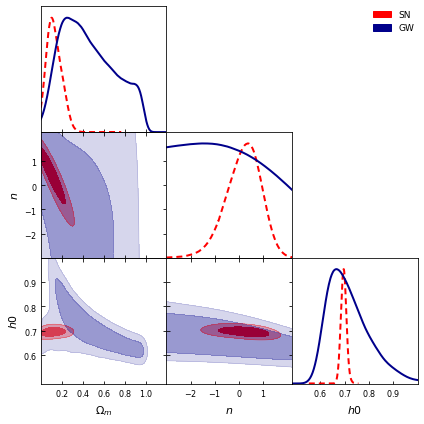

In [69]:
# Export the results to GetDist
from getdist.mcsamples import MCSamplesFromCobaya

gd_sample_SN = MCSamplesFromCobaya(updated_info_SN, sampler_SN.products()["sample"])
# Analyze and plot
mean_SN = gd_sample_SN.getMeans()[:3]
covmat_SN = gd_sample_SN.getCovMat().matrix[:3, :3]
print("Mean:")
print(mean_SN)
print("Covariance matrix:")
print(covmat_SN)
# %matplotlib inline  # uncomment if running from the Jupyter notebook
# import getdist.plots as gdplt

# gdplot_SN = gdplt.get_subplot_plotter()
# gdplot_SN.triangle_plot(gd_sample_SN, ["omega_m", "n", "h0"], filled=True)

gd_sample_GW = MCSamplesFromCobaya(updated_info_GW, sampler_GW.products()["sample"])
# Analyze and plot
mean_GW = gd_sample_GW.getMeans()[:3]
covmat_GW = gd_sample.getCovMat().matrix[:3, :3]
print("Mean: ")
print(mean_GW)
print("Covariance matrix:")
print(covmat_GW)
# %matplotlib inline  # uncomment if running from the Jupyter notebook
import getdist.plots as gdplt

# gdplot_GW = gdplt.get_subplot_plotter()
# gdplot_GW.triangle_plot(gd_sample_GW, ["omega_m", "n", "h0"], filled=True)



g = gdplt.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add=0.4
g.settings.title_limit_fontsize = 14
g.triangle_plot([gd_sample_SN, gd_sample_GW], ["omega_m", "n", "h0"], 
    filled=True, 
    legend_labels=['SN', 'GW'], 
    legend_loc='upper right', 
    line_args=[{'lw':2,'ls':'--', 'color':'red'},
               {'lw':2, 'color':'darkblue'}], 
    contour_colors=['red','darkblue'],
#     title_limit=1, # first title limit (for 1D plots) is 68% by default
#     markers={'h0':0}
               )

In [43]:
name=np.array(['GW190521','GW190706_222641','GW190413_134308','GW190514_065416','GW190719_215514','GW190521',"GW190909_114149","GW190413_052954",'GW190803_022701','GW190731_140936','GW190727_060333','GW190620_030421','GW190421_213856','GW170729','GW190602_175927','GW190527_092055','GW190519_153544','GW190424_180648','GW190929_012149','GW190828_063405','GW190701_203306','GW190513_205428','GW170823','GW190517_055101','GW190915_235702','GW190828_065509','GW190408_181802','GW190910_112807','GW190512_180714','GW190503_185404','GW190521_074359','GW170818','GW151012','GW170809','GW170104','GW190728_064510','GW190708_232457','GW190630_185205','GW190720_000836','GW190707_093326','GW190930_133541','GW190412','GW190924_021846','GW170814','GW151226','GW150914','GW190426_152155','GW200115_042309','GW170608','GW200105_162426','GW190814','GW190425','GW170817'])
full_DL_GW=np.array([[5300.0,2400,-2600],[4420.0,2590,-1930],[4450,2480,-2120],[4130.0,2650,-2170],[3940.0,2590,-2000],[3920.0,2190,-1950],[3770.0,3270,-2220],[3550.0,2270,-1660],[3270.0,1950,-1580],[3300.0,2390,-1720],[3300.0,1540,-1500],[2810.0,1680,-1310],[2880.0,1370,-1380],[2840.0,1400,-1360],[2690.0,1790,-1120],[2490.0,2480,-1240],[2530.0,1830,-920],[2200.0,1580,-1160],[2130.0,3650,-1050],[2130.0,660,-930],[2060.0,760,-730],[2060.0,880,-800],[1940.0,970,-900],[1860.0,1620,-840],[1620.0,710,-610],[1600.0,620,-600],[1550.0,400,-600],[1460.0,1030,-580],[1430.0,550,-550],[1450.0,690,-630],[1240.0,400,-570],[1060.0,420,-380],[1080.0,550,-490],[1030.0,320,-390],[990.0,440,-430],[870.0,260,-370],[880.0,330,-390],[890.0,560,-370],[790.0,690,-320],[770.0,380,-370],[760.0,360,-320],[740.0,140,-170],[570.0,220,-220],[600.0,150,-220],[450.0,180,-190],[440.0,150,-170],[370.0,180,-160],[300.0,150,-100],[320.0,120,-110],[280.0,110,-110],[241.0,41,-45],[159.0,69,-72],[40.0,7,-15]])
full_Z_GW=np.array([[0.82,0.28,-0.34],[0.71,0.32,-0.27],[0.71,0.31,-0.30],[0.67,0.33,-0.31],[0.64,0.33,-0.29],[0.64,0.28,-0.28],[0.62,0.41,-0.33],[0.59,0.29,-0.24],[0.55,0.26,-0.24],[0.55,0.31,-0.26],[0.55,0.21,-0.22],[0.49,0.23,-0.20],[0.49,0.19,-0.21],[0.49,0.19,-0.21],[0.47,0.25,-0.17],[0.44,0.34,-0.20],[0.44,0.25,-0.14],[0.39,0.23,-0.19],[0.38,0.49,-0.17],[0.38,0.10,-0.15],[0.37,0.11,-0.12],[0.37,0.13,-0.13],[0.35,0.15,-0.15],[0.34,0.24,-0.14],[0.3,0.11,-0.10],[0.3,0.10,-0.10],[0.29,0.06,-0.10],[0.28,0.16,-0.10],[0.27,0.09,-0.10],[0.27,0.11,-0.11],[0.24,0.07,-0.10],[0.21,0.07,-0.07],[0.21,0.09,-0.09],[0.2,0.05,-0.07],[0.2,0.08,-0.08],[0.18,0.05,-0.07],[0.18,0.06,-0.07],[0.18,0.10,-0.07],[0.16,0.12,-0.06],[0.16,0.07,-0.07],[0.15,0.06,-0.06],[0.15,0.03,-0.03],[0.12,0.04,-0.04],[0.12,0.03,-0.04],[0.09,0.04,-0.04],[0.09,0.03,-0.03],[0.08,0.04,-0.03],[0.07,0.03,-0.02],[0.07,0.02,-0.02],[0.06,0.02,-0.02],[0.053,0.009,-0.010],[0.04,0.01,-0.02],[0.01,0.00,-0.00]])
# Number of events
a=name.size

#Defining arrays
dldata_GW=np.zeros(a)
dlUP=np.zeros(a)
dlLOW=np.zeros(a)
dlTOP=np.zeros(a)
dlBOTTOM=np.zeros(a)
dmtop=np.zeros(a)
dmbottom=np.zeros(a)
Z_GW=np.zeros(a)
dmth_GW=np.zeros(a)
dmdata_GW=np.zeros(a)
dlth_GW = np.zeros(a)
dmtoperr=np.zeros(a)
dmbottomerr=np.zeros(a)
#defining variables for index of the above arrays
b=c=d=e=f=h=k=l=m=x=y=p=q=r=s=0
#extracting redshifts and DL from the full data
for i in full_Z_GW:
  Z_GW[e]+=i[0]
  e+=1
for i in full_DL_GW:
  dldata_GW[b]+=i[0]
  b+=1
for i in dldata_GW:
  dmdata_GW[h]+=5*log(i,10)+25
  h+=1
for i in full_DL_GW:
  dlUP[c]+=i[0]+i[1]
  c+=1
for i in full_DL_GW:
  dlLOW[d]+=i[0]+i[2]
  d+=1
label1 = {"Event_Name":name,"Z_GW":Z_GW,"dLdata_GW":dldata_GW,"DMdata_GW": dmdata_GW,"DL_Uplimit": dlUP, "DL_Lowlimit": dlLOW}
data_GW=pd.DataFrame(label1)
data_GWTC3 = pd.read_excel (r'/root/Github_Repos/VCG_GW/oldGW.xlsx')
data_GWTC3.index= np.arange(53,88)

mucollect=[data_GW.Z_GW,data_GWTC3.redshift]
z1 = pd.concat(mucollect)

namecollect=[data_GW.Event_Name,data_GWTC3.Event_Name_GWTC3]
finalevents = pd.concat(namecollect)

dlcollect=[data_GW.dLdata_GW,data_GWTC3.luminosity_distance]
finaldl1 = pd.concat(dlcollect)

dlupcollect=[data_GW.DL_Uplimit,data_GWTC3.luminosity_distance_upper]
finaldlup1 = pd.concat(dlupcollect)

dllowcollect=[data_GW.DL_Lowlimit,data_GWTC3.luminosity_distance_lower]
finaldllow1 = pd.concat(dllowcollect)
label2 = {"EventName":finalevents,"ZGW":z1,"dLdataGW":finaldl1,"DLUplimit":finaldlup1,"DLLowlimit":finaldllow1}
Final_GW=pd.DataFrame(label2)
sort_data_GW=Final_GW.sort_values(by=['ZGW'],ignore_index=True)

z=sort_data_GW.ZGW
finaldl=sort_data_GW.dLdataGW
finaldlup=sort_data_GW.DLUplimit
finaldllow=sort_data_GW.DLLowlimit
a=finalevents.size

#Defining arrays
dlTOP=np.zeros(a)
dlBOTTOM=np.zeros(a)
dmtop=np.zeros(a)
dmbottom=np.zeros(a)
dmth3_GW=np.zeros(a)
mu=np.zeros(a)
dlth3_GW = np.zeros(a)
dmtoperr=np.zeros(a)
dmbottomerr=np.zeros(a)
#defining variables for index of the above arrays
f=h=k=l=m=x=y=p=q=r=s=0

for i in finaldl:
  mu[h]+=5*log(i,10)+25
  h+=1
for i in finaldlup:
  dmtop[f]+=5*log(i,10)+25
  f+=1
for i in finaldllow:
  dmbottom[k]+=5*log(i,10)+25
  k+=1
#upper and lower differences for errors
for (i,j) in zip(mu,dmtop):
  dmtoperr[r]+=j-i
  r+=1
for (i,j) in zip(mu,dmbottom):
  dmbottomerr[s]+=i-j
  s+=1

In [44]:
#number of samples 
sampl= 10000
#number of pars
par = 2

sigma=(dmtoperr+dmbottomerr)/2
#assume the parameters have a gaussian distribution
sigma_omega= 0.01
sigma_n= 0.01
omega_b0 = 0.0000245
omega_r0=0.02


#Defining part which comes inside integeration of distance Luminosity


dmthSN= np.zeros(len(z))
dlthSN = np.zeros(len(z))
dldataSN=np.zeros(len(z))
error= np.zeros(len(z))
dlerror= np.zeros(len(z))

a=b=c=d=e=0
# DL theoretical from VCG model
def D_l(z,omega_m,n,h0):
    def int_func(x):
        return 1/(pow((1+x),2)*(omega_r0+(omega_b0/(1+x))+((1-omega_b0-omega_r0)*((omega_m*(1+x)**6)+(1-omega_m)*(1+z)**n)**(0.5)/(1+x)**(4)))**(0.5))
    g = quad(int_func,0,z)
    return (1+z)*g[0]*(3000/(h0))
#Function to calculate the value of mu_theory
def mu_theory(z,omega_m,n,h0):
        m=5*log(D_l(z,omega_m,n,h0),10)+25
        return m

# We now defile a likelihood function as given in the notes
# If the value comes out to be less than zero, set it to a very very small likelyhood
#Temporary variable to store mu(observation)- mu(theory)
dmu= np.empty(len(z))
def lnl(omega_m, n,h0):
        if(omega_m<=0.0 or omega_m>=1 or h0<0):
            loglikely=-1.e100
        else:
            for i in range(len(z)):
                dmu[i]= mu[i]- mu_theory(z[i],omega_m,n,h0)
            loglikely= -0.5*np.sum(dmu**2/sigma**2)
        return loglikely

In [45]:
info_GW = {
    "likelihood": {
        "external": lnl},
    "params": dict([
        ("omega_m", {
            "prior": {"min": 0, "max": 2.5},
            "latex": r"\Omega_m"}),
        ("n", {
            "prior": {"min": -25, "max": 4},
            "latex": r"n"}),
        ("h0", {
            "prior": {"min": 0, "max": 2},
            "latex": r"h0"}) ]),
    "sampler": {
        "mcmc": {"Rminus1_stop": 0.01, 'max_tries':10000}}}

In [46]:
from cobaya.run import run

updated_info_GW, sampler_GW = run(info_GW)

[external] Initialized external likelihood.
[mcmc] Getting initial point... (this may take a few seconds)
[prior] Reference values or pdfs for some parameters were not provided. Sampling from the prior instead for those parameters.
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {external: 190.0}
[prior] *WARNING* Reference pdf not defined or improper for some parameters. Using prior's sigma instead for them.
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Initial point: omega_m:1.031238, n:-23.05768, h0:1.99349
[mcmc] Sampling!
[mcmc] Progress @ 2022-02-17 21:10:56 : 1 steps taken, and 0 accepted.
[mcmc] Learn + convergence test @ 120 samples accepted.
[mcmc]  - Acceptance rate: 0.100
[mcmc]  - Convergence of means: R-1 = 1.070644 after 96 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergen

[mcmc]  - Acceptance rate: 0.207
[mcmc]  - Convergence of means: R-1 = 0.009955 after 3360 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 4320 samples accepted.
[mcmc]  - Acceptance rate: 0.207
[mcmc]  - Convergence of means: R-1 = 0.010396 after 3456 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 4440 samples accepted.
[mcmc]  - Acceptance rate: 0.208
[mcmc]  - Convergence of means: R-1 = 0.005364 after 3552 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 4560 samples accepted.
[mcmc]  - Acceptance rate: 0.209
[mcmc]  - Convergence of means: R-1 = 0.010422 after 3648 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 4680 samples accepted.
[mcmc]  - Acceptance rate: 0.209
[mcmc]  - Convergence of means: R-1 = 0.010941 after 3744 accepted steps
[mcmc]  - Updated covariance m

[mcmc] Learn + convergence test @ 8760 samples accepted.
[mcmc]  - Acceptance rate: 0.213
[mcmc]  - Convergence of means: R-1 = 0.003642 after 7008 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 8880 samples accepted.
[mcmc]  - Acceptance rate: 0.212
[mcmc]  - Convergence of means: R-1 = 0.004423 after 7104 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 9000 samples accepted.
[mcmc]  - Acceptance rate: 0.212
[mcmc]  - Convergence of means: R-1 = 0.005961 after 7200 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 9120 samples accepted.
[mcmc]  - Acceptance rate: 0.212
[mcmc]  - Convergence of means: R-1 = 0.007581 after 7296 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 9240 samples accepted.
[mcmc]  - Acceptance rate: 0.212
[mcmc]  - Convergence of means: R-1 = 0.008207

[mcmc]  - Convergence of means: R-1 = 0.012867 after 10560 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 13320 samples accepted.
[mcmc]  - Acceptance rate: 0.210
[mcmc]  - Convergence of means: R-1 = 0.012411 after 10656 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Progress @ 2022-02-17 21:14:56 : 64197 steps taken, and 13411 accepted.
[mcmc] Learn + convergence test @ 13440 samples accepted.
[mcmc]  - Acceptance rate: 0.210
[mcmc]  - Convergence of means: R-1 = 0.013434 after 10752 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 13560 samples accepted.
[mcmc]  - Acceptance rate: 0.210
[mcmc]  - Convergence of means: R-1 = 0.012940 after 10848 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 13680 samples accepted.
[mcmc]  - Acceptance rate: 0.211
[mcmc]  - Convergence of means: R-1 = 0.011283 af

[mcmc]  - Convergence of means: R-1 = 0.006840 after 14112 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 17760 samples accepted.
[mcmc]  - Acceptance rate: 0.212
[mcmc]  - Convergence of means: R-1 = 0.006460 after 14208 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 17880 samples accepted.
[mcmc]  - Acceptance rate: 0.212
[mcmc]  - Convergence of means: R-1 = 0.008732 after 14304 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 18000 samples accepted.
[mcmc]  - Acceptance rate: 0.212
[mcmc]  - Convergence of means: R-1 = 0.008252 after 14400 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 18120 samples accepted.
[mcmc]  - Acceptance rate: 0.212
[mcmc]  - Convergence of means: R-1 = 0.010792 after 14496 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[

[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 22200 samples accepted.
[mcmc]  - Acceptance rate: 0.213
[mcmc]  - Convergence of means: R-1 = 0.003528 after 17760 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 22320 samples accepted.
[mcmc]  - Acceptance rate: 0.213
[mcmc]  - Convergence of means: R-1 = 0.003675 after 17856 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 22440 samples accepted.
[mcmc]  - Acceptance rate: 0.212
[mcmc]  - Convergence of means: R-1 = 0.003574 after 17952 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 22560 samples accepted.
[mcmc]  - Acceptance rate: 0.212
[mcmc]  - Convergence of means: R-1 = 0.003547 after 18048 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 22680 samples accepted.
[mcmc]  - Accepta

[mcmc] Learn + convergence test @ 26640 samples accepted.
[mcmc]  - Acceptance rate: 0.212
[mcmc]  - Convergence of means: R-1 = 0.004374 after 21312 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Progress @ 2022-02-17 21:18:56 : 126390 steps taken, and 26736 accepted.
[mcmc] Learn + convergence test @ 26760 samples accepted.
[mcmc]  - Acceptance rate: 0.213
[mcmc]  - Convergence of means: R-1 = 0.005528 after 21408 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 26880 samples accepted.
[mcmc]  - Acceptance rate: 0.213
[mcmc]  - Convergence of means: R-1 = 0.005820 after 21504 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 27000 samples accepted.
[mcmc]  - Acceptance rate: 0.212
[mcmc]  - Convergence of means: R-1 = 0.005638 after 21600 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 27120 samples 

[mcmc] Learn + convergence test @ 31080 samples accepted.
[mcmc]  - Acceptance rate: 0.212
[mcmc]  - Convergence of means: R-1 = 0.001928 after 24864 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 31200 samples accepted.
[mcmc]  - Acceptance rate: 0.212
[mcmc]  - Convergence of means: R-1 = 0.002173 after 24960 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 31320 samples accepted.
[mcmc]  - Acceptance rate: 0.212
[mcmc]  - Convergence of means: R-1 = 0.002460 after 25056 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 31440 samples accepted.
[mcmc]  - Acceptance rate: 0.212
[mcmc]  - Convergence of means: R-1 = 0.002901 after 25152 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 31560 samples accepted.
[mcmc]  - Acceptance rate: 0.212
[mcmc]  - Convergence of means: R-1 =

[mcmc] Learn + convergence test @ 35520 samples accepted.
[mcmc]  - Acceptance rate: 0.211
[mcmc]  - Convergence of means: R-1 = 0.001632 after 28416 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 35640 samples accepted.
[mcmc]  - Acceptance rate: 0.211
[mcmc]  - Convergence of means: R-1 = 0.001572 after 28512 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 35760 samples accepted.
[mcmc]  - Acceptance rate: 0.211
[mcmc]  - Convergence of means: R-1 = 0.001558 after 28608 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 35880 samples accepted.
[mcmc]  - Acceptance rate: 0.211
[mcmc]  - Convergence of means: R-1 = 0.001508 after 28704 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 36000 samples accepted.
[mcmc]  - Acceptance rate: 0.211
[mcmc]  - Convergence of means: R-1 =

[mcmc]  - Acceptance rate: 0.211
[mcmc]  - Convergence of means: R-1 = 0.002899 after 31968 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 40080 samples accepted.
[mcmc]  - Acceptance rate: 0.211
[mcmc]  - Convergence of means: R-1 = 0.003718 after 32064 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 40200 samples accepted.
[mcmc]  - Acceptance rate: 0.211
[mcmc]  - Convergence of means: R-1 = 0.003810 after 32160 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 40320 samples accepted.
[mcmc]  - Acceptance rate: 0.211
[mcmc]  - Convergence of means: R-1 = 0.003176 after 32256 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 40440 samples accepted.
[mcmc]  - Acceptance rate: 0.211
[mcmc]  - Convergence of means: R-1 = 0.002991 after 32352 accepted steps
[mcmc]  - Updated cov

[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 44520 samples accepted.
[mcmc]  - Acceptance rate: 0.211
[mcmc]  - Convergence of means: R-1 = 0.002509 after 35616 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 44640 samples accepted.
[mcmc]  - Acceptance rate: 0.211
[mcmc]  - Convergence of means: R-1 = 0.002377 after 35712 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 44760 samples accepted.
[mcmc]  - Acceptance rate: 0.211
[mcmc]  - Convergence of means: R-1 = 0.002243 after 35808 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 44880 samples accepted.
[mcmc]  - Acceptance rate: 0.211
[mcmc]  - Convergence of means: R-1 = 0.002307 after 35904 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 45000 samples accepted.
[mcmc]  - Accepta

[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 48960 samples accepted.
[mcmc]  - Acceptance rate: 0.210
[mcmc]  - Convergence of means: R-1 = 0.002528 after 39168 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 49080 samples accepted.
[mcmc]  - Acceptance rate: 0.210
[mcmc]  - Convergence of means: R-1 = 0.002584 after 39264 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 49200 samples accepted.
[mcmc]  - Acceptance rate: 0.210
[mcmc]  - Convergence of means: R-1 = 0.002664 after 39360 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 49320 samples accepted.
[mcmc]  - Acceptance rate: 0.210
[mcmc]  - Convergence of means: R-1 = 0.002676 after 39456 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 49440 samples accepted.
[mcmc]  - Accepta

[mcmc] Learn + convergence test @ 53400 samples accepted.
[mcmc]  - Acceptance rate: 0.209
[mcmc]  - Convergence of means: R-1 = 0.003517 after 42720 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 53520 samples accepted.
[mcmc]  - Acceptance rate: 0.209
[mcmc]  - Convergence of means: R-1 = 0.003884 after 42816 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 53640 samples accepted.
[mcmc]  - Acceptance rate: 0.209
[mcmc]  - Convergence of means: R-1 = 0.003852 after 42912 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 53760 samples accepted.
[mcmc]  - Acceptance rate: 0.209
[mcmc]  - Convergence of means: R-1 = 0.003930 after 43008 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 53880 samples accepted.
[mcmc]  - Acceptance rate: 0.209
[mcmc]  - Convergence of means: R-1 =

[mcmc] Learn + convergence test @ 57840 samples accepted.
[mcmc]  - Acceptance rate: 0.209
[mcmc]  - Convergence of means: R-1 = 0.002655 after 46272 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 57960 samples accepted.
[mcmc]  - Acceptance rate: 0.209
[mcmc]  - Convergence of means: R-1 = 0.002706 after 46368 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 58080 samples accepted.
[mcmc]  - Acceptance rate: 0.209
[mcmc]  - Convergence of means: R-1 = 0.002712 after 46464 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 58200 samples accepted.
[mcmc]  - Acceptance rate: 0.209
[mcmc]  - Convergence of means: R-1 = 0.002599 after 46560 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 58320 samples accepted.
[mcmc]  - Acceptance rate: 0.209
[mcmc]  - Convergence of means: R-1 =

[mcmc]  - Acceptance rate: 0.209
[mcmc]  - Convergence of means: R-1 = 0.001367 after 49824 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 62400 samples accepted.
[mcmc]  - Acceptance rate: 0.209
[mcmc]  - Convergence of means: R-1 = 0.001348 after 49920 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 62520 samples accepted.
[mcmc]  - Acceptance rate: 0.209
[mcmc]  - Convergence of means: R-1 = 0.001354 after 50016 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 62640 samples accepted.
[mcmc]  - Acceptance rate: 0.209
[mcmc]  - Convergence of means: R-1 = 0.001356 after 50112 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 62760 samples accepted.
[mcmc]  - Acceptance rate: 0.209
[mcmc]  - Convergence of means: R-1 = 0.001342 after 50208 accepted steps
[mcmc]  - Updated cov

[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 66840 samples accepted.
[mcmc]  - Acceptance rate: 0.209
[mcmc]  - Convergence of means: R-1 = 0.002080 after 53472 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 66960 samples accepted.
[mcmc]  - Acceptance rate: 0.209
[mcmc]  - Convergence of means: R-1 = 0.002077 after 53568 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 67080 samples accepted.
[mcmc]  - Acceptance rate: 0.209
[mcmc]  - Convergence of means: R-1 = 0.001946 after 53664 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Progress @ 2022-02-17 21:31:56 : 321136 steps taken, and 67158 accepted.
[mcmc] Learn + convergence test @ 67200 samples accepted.
[mcmc]  - Acceptance rate: 0.209
[mcmc]  - Convergence of means: R-1 = 0.002059 after 53760 accepted steps
[mcmc]  - Updated covariance matrix of proposal 

[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 71280 samples accepted.
[mcmc]  - Acceptance rate: 0.209
[mcmc]  - Convergence of means: R-1 = 0.001059 after 57024 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 71400 samples accepted.
[mcmc]  - Acceptance rate: 0.209
[mcmc]  - Convergence of means: R-1 = 0.001145 after 57120 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 71520 samples accepted.
[mcmc]  - Acceptance rate: 0.209
[mcmc]  - Convergence of means: R-1 = 0.001279 after 57216 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 71640 samples accepted.
[mcmc]  - Acceptance rate: 0.209
[mcmc]  - Convergence of means: R-1 = 0.001166 after 57312 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 71760 samples accepted.
[mcmc]  - Accepta

Mean: 
[  0.45833774 -10.61189972   0.71911621]
Covariance matrix:
[[ 6.35242325e-02 -8.21768153e-02 -1.57841885e-02]
 [-8.21768153e-02  6.50680852e+01 -2.86111842e-01]
 [-1.57841885e-02 -2.86111842e-01  8.10825431e-03]]


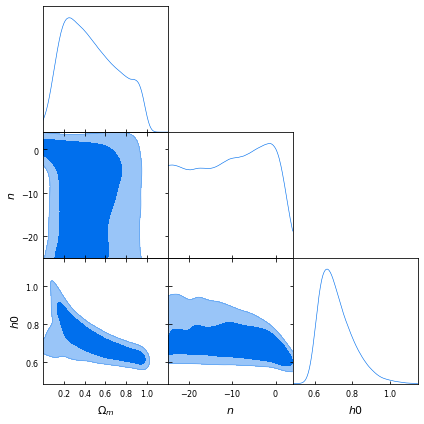

In [47]:
# Export the results to GetDist
from getdist.mcsamples import MCSamplesFromCobaya

gd_sample_GW = MCSamplesFromCobaya(updated_info_GW, sampler_GW.products()["sample"])
# Analyze and plot
mean_GW = gd_sample_GW.getMeans()[:3]
covmat_GW = gd_sample.getCovMat().matrix[:3, :3]
print("Mean: ")
print(mean_GW)
print("Covariance matrix:")
print(covmat_GW)
# %matplotlib inline  # uncomment if running from the Jupyter notebook
import getdist.plots as gdplt

gdplot_GW = gdplt.get_subplot_plotter()
gdplot_GW.triangle_plot(gd_sample, ["omega_m", "n", "h0"], filled=True)

NameError: name 'cobaya' is not defined

In [7]:
info_PT = {
    "likelihood": {   'sn.pantheon':
    {'path': '/root/anaconda3/lib/python3.8/site-packages/cobaya/likelihoods/sn/data/sn_data'}
        },
    'theory': {'classy': {} },
    "params": dict([
        ("omega_m", {
            "prior": {"min": 0, "max": 2.5},
            "latex": r"\Omega_m"}),
        ("n", {
            "prior": {"min": -25, "max": 4},
            "latex": r"n"}),
        ("h0", {
            "prior": {"min": 0, "max": 2},
            "latex": r"h0"}) ]),
    "sampler": {
        "mcmc": {"Rminus1_stop": 0.01, 'max_tries':10000}}}

#"sn.pantheon": {'python_path': '.'}
# cobaya_H0_ext.MCP:
#     python_path: .
#   cobaya_H0_ext.H0LiCOW:
#     python_path:

In [8]:
updated_info_PT, sampler_PT = run(info_PT)

[classy] Importing *global* CLASS.
[classy] *ERROR* component classy at /root/.local/lib/python3.8/site-packages is version (non-given) but required v2.9.3 or higher
[classy] *ERROR* Could not find CLASS. Check error message above.


NotInstalledError: Could not find CLASS. Check error message above.

In [ ]:
# Export the results to GetDist
from getdist.mcsamples import MCSamplesFromCobaya

gd_sample_SN = MCSamplesFromCobaya(updated_info_SN, sampler_SN.products()["sample"])
# Analyze and plot
mean_SN = gd_sample_SN.getMeans()[:3]
covmat_SN = gd_sample_SN.getCovMat().matrix[:3, :3]
print("Mean:")
print(mean_SN)
print("Covariance matrix:")
print(covmat_SN)
# %matplotlib inline  # uncomment if running from the Jupyter notebook
# import getdist.plots as gdplt

# gdplot_SN = gdplt.get_subplot_plotter()
# gdplot_SN.triangle_plot(gd_sample_SN, ["omega_m", "n", "h0"], filled=True)

gd_sample_GW = MCSamplesFromCobaya(updated_info_GW, sampler_GW.products()["sample"])
# Analyze and plot
mean_GW = gd_sample_GW.getMeans()[:3]
covmat_GW = gd_sample.getCovMat().matrix[:3, :3]
print("Mean: ")
print(mean_GW)
print("Covariance matrix:")
print(covmat_GW)
# %matplotlib inline  # uncomment if running from the Jupyter notebook
import getdist.plots as gdplt

# gdplot_GW = gdplt.get_subplot_plotter()
# gdplot_GW.triangle_plot(gd_sample_GW, ["omega_m", "n", "h0"], filled=True)



g = gdplt.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add=0.4
g.settings.title_limit_fontsize = 14
g.triangle_plot([gd_sample_SN, gd_sample_GW], ["omega_m", "n", "h0"], 
    filled=True, 
    legend_labels=['SN', 'GW'], 
    legend_loc='upper right', 
    line_args=[{'lw':2,'ls':'--', 'color':'red'},
               {'lw':2, 'color':'darkblue'}], 
    contour_colors=['red','darkblue'],
#     title_limit=1, # first title limit (for 1D plots) is 68% by default
#     markers={'h0':0}
               )